In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import numpy as np

In [2]:
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents = True, exist_ok = True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path = "datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [5]:
import matplotlib.pyplot as plt

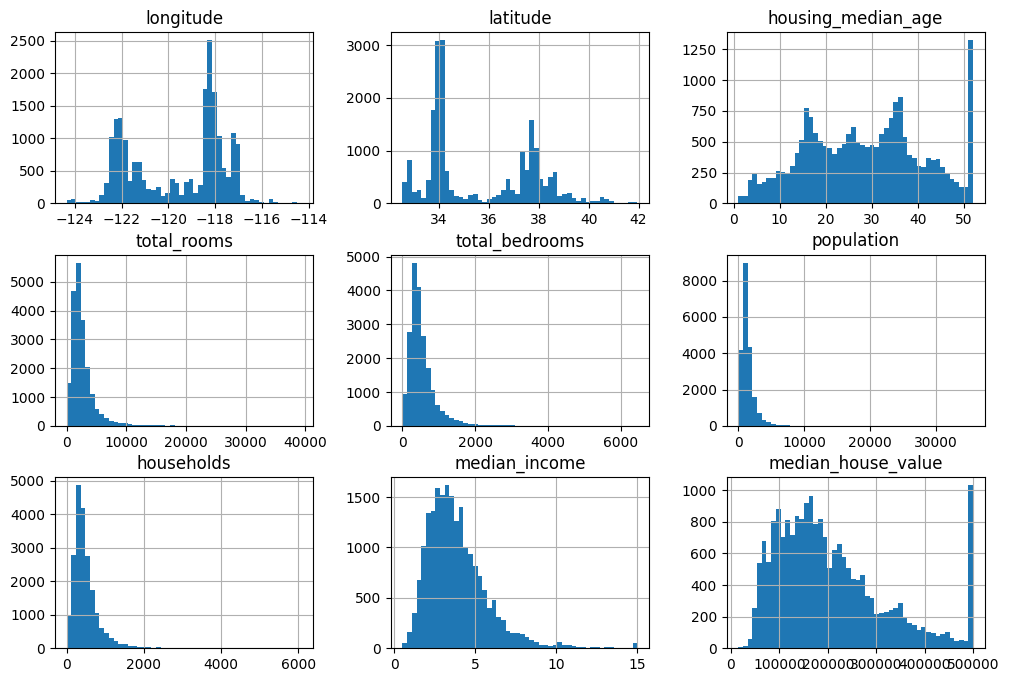

In [6]:
housing.hist(bins = 50, figsize = (12,8))
plt.show()

In [7]:
def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [8]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)

In [9]:
len(train_set), len(test_set)

(16512, 4128)

In [10]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2 ** 32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

                            

In [11]:
housing_with_id = housing.reset_index()
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

In [12]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state= 42)

In [13]:
housing['income_cat'] = pd.cut(housing['median_income'], bins = [0, 1.5, 3.0, 4.5, 5, np.inf], labels = [1,2,3,4,5])

In [14]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,5
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3
...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND,2
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND,2
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND,2
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND,2


Text(0, 0.5, 'Number of districts')

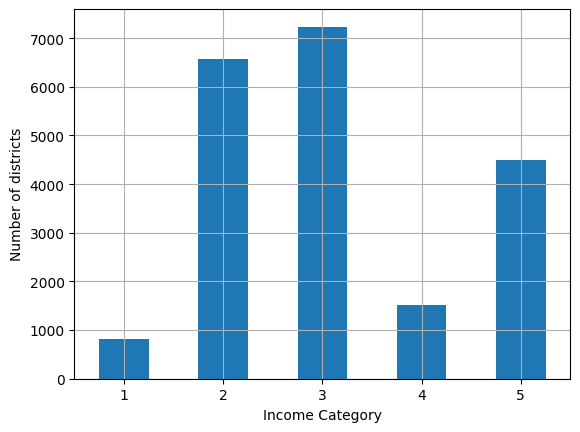

In [15]:
housing['income_cat'].value_counts().sort_index().plot.bar(rot = 0, grid = True)
plt.xlabel("Income Category")
plt.ylabel("Number of districts")

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing['income_cat']):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

In [17]:
strat_train_set, strat_test_set = strat_splits[0]

In [18]:
strat_train_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
20217,-121.26,37.95,44.0,819.0,184.0,677.0,183.0,1.7250,59300.0,INLAND,2
17424,-117.17,32.80,20.0,2827.0,554.0,1822.0,536.0,3.4706,157600.0,NEAR OCEAN,3
7308,-118.16,34.03,45.0,894.0,231.0,925.0,222.0,2.6042,145000.0,<1H OCEAN,2
12266,-118.45,34.03,41.0,1240.0,320.0,711.0,304.0,3.3482,318100.0,<1H OCEAN,3
2244,-122.25,38.10,52.0,1591.0,372.0,817.0,357.0,2.1411,97200.0,NEAR BAY,2
...,...,...,...,...,...,...,...,...,...,...,...
2688,-117.27,33.03,25.0,1787.0,311.0,1108.0,311.0,3.9826,215800.0,NEAR OCEAN,3
20136,-120.76,38.12,7.0,7188.0,1288.0,3175.0,1115.0,3.8488,130600.0,INLAND,3
18739,-122.11,37.37,22.0,1477.0,195.0,520.0,187.0,10.3329,500001.0,NEAR BAY,5
11072,-115.62,33.04,17.0,1009.0,231.0,745.0,217.0,2.0463,61200.0,INLAND,2


In [19]:
strat_train_set, strat_test_set = train_test_split(housing, test_size = 0.2, stratify=housing['income_cat'], random_state = 42)

In [20]:
strat_train_set['income_cat'].value_counts()/len(strat_train_set)

income_cat
3    0.350594
2    0.318859
5    0.217478
4    0.073280
1    0.039789
Name: count, dtype: float64

In [21]:
strat_test_set['income_cat'].value_counts()/len(strat_test_set)

income_cat
3    0.350533
2    0.318798
5    0.217539
4    0.073159
1    0.039971
Name: count, dtype: float64

In [22]:
housing['income_cat'].value_counts()/len(housing)

income_cat
3    0.350581
2    0.318847
5    0.217490
4    0.073256
1    0.039826
Name: count, dtype: float64

In [23]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis =1 , inplace = True)

In [24]:
housing = strat_train_set.copy()

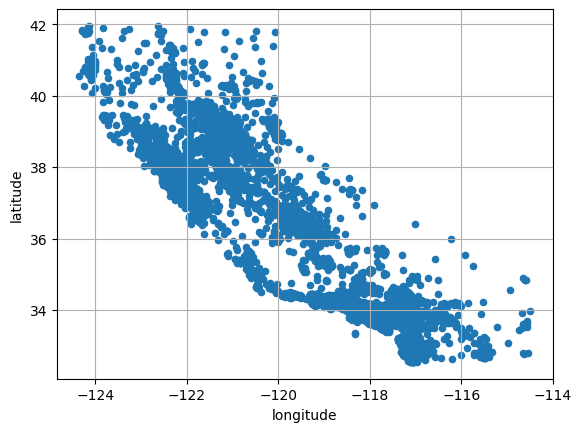

In [25]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude", grid = True)
plt.show()

In [26]:
housing = housing.drop("ocean_proximity", axis = 1)

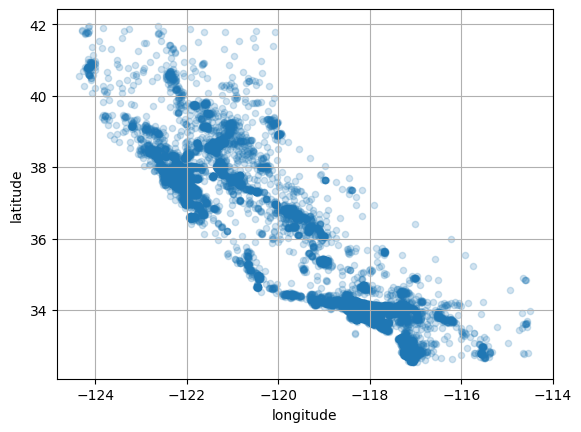

In [27]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude", grid = True, alpha = 0.2)
plt.show()

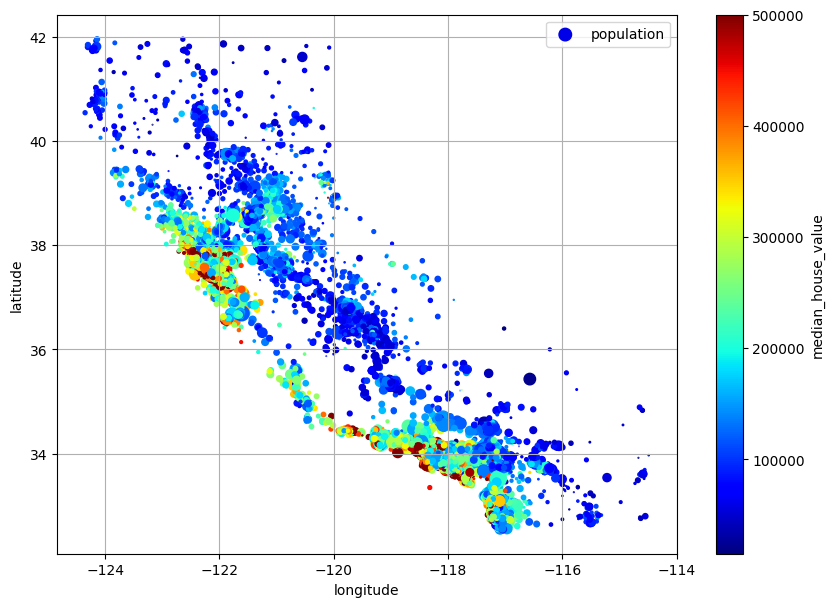

In [28]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude", grid = True, 
             s = housing['population'] / 100, label = "population", 
             c = "median_house_value", cmap = "jet", colorbar = True, legend = True, 
             sharex = False, figsize = (10,7))
plt.show()

In [29]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.691701
total_rooms           0.138372
housing_median_age    0.108138
households            0.070919
total_bedrooms        0.053885
population           -0.019877
longitude            -0.050177
latitude             -0.140510
Name: median_house_value, dtype: float64

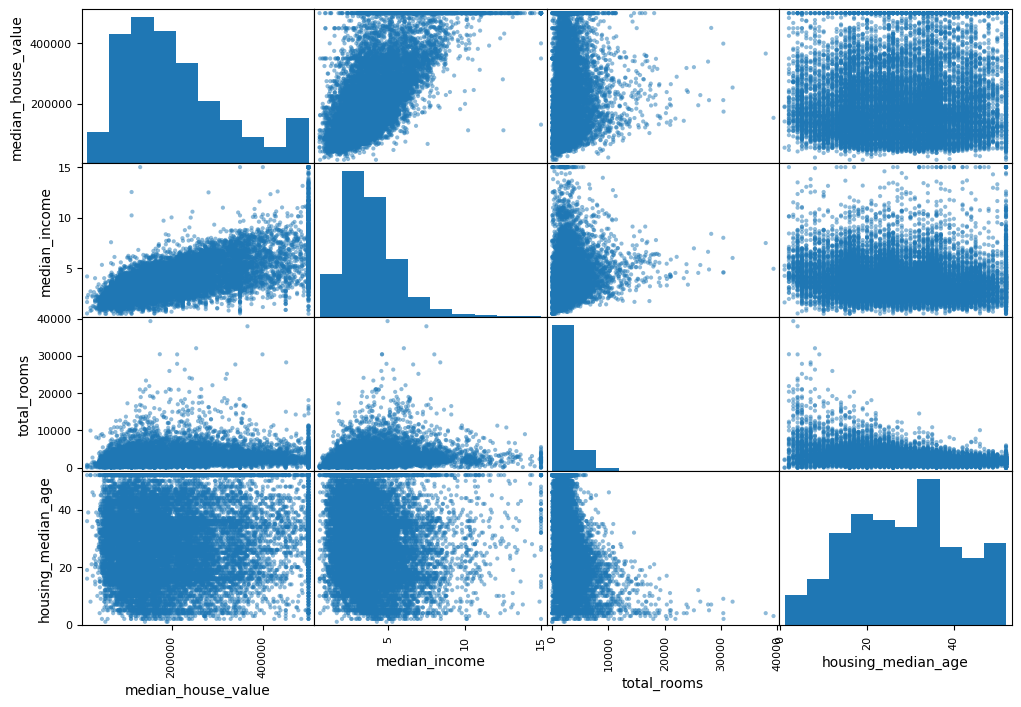

In [30]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize = (12,8))
plt.show()

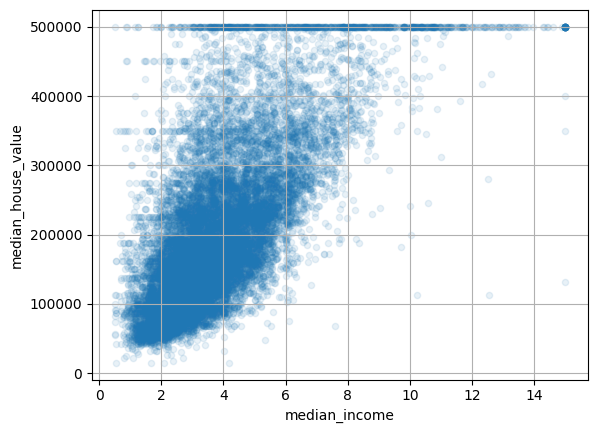

In [31]:
housing.plot(kind = "scatter", x = "median_income", y = "median_house_value", alpha = 0.1, grid = True)
plt.show()

In [32]:
housing['rooms_per_house'] = housing['total_rooms']/housing['households']
housing['bedrooms_ratio'] = housing['total_bedrooms'] / housing['total_rooms']
housing['people_per_house'] = housing['population'] / housing['households']

In [33]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.691701
rooms_per_house       0.147745
total_rooms           0.138372
housing_median_age    0.108138
households            0.070919
total_bedrooms        0.053885
population           -0.019877
people_per_house     -0.033123
longitude            -0.050177
latitude             -0.140510
bedrooms_ratio       -0.262690
Name: median_house_value, dtype: float64

In [34]:
housing = strat_train_set.drop("median_house_value", axis = 1)
housing_labels = strat_train_set['median_house_value'].copy()

In [35]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = "median")

In [36]:
housing_num = housing.select_dtypes(include = [np.number])

In [37]:
housing_num.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 20217 to 15851
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16338 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


In [38]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [39]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.5   ,  433.    , 1166.    ,
        408.    ,    3.5385])

In [40]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.5   ,  433.    , 1166.    ,
        408.    ,    3.5385])

In [41]:
X = imputer.transform(housing_num)

In [42]:
housing_tr = pd.DataFrame(X, columns = housing_num.columns, index = housing_num.index)

In [43]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(8)

,ocean_proximity
20217,INLAND
17424,NEAR OCEAN
7308,<1H OCEAN
12266,<1H OCEAN
2244,NEAR BAY
5192,<1H OCEAN
3483,<1H OCEAN
14865,NEAR BAY


In [44]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [45]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [46]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat) # * OneHotEncoder remembers categories

In [47]:
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


In [48]:
cat_encoder.transform(df_test).toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [49]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [50]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1,1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num) # * subtracts each by the min and divides by the difference between the Min and Max

In [51]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num) # * subtracts by the mean and divides by the standard of deviation

In [52]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma = 0.1)

In [53]:
housing_labels

20217     59300.0
17424    157600.0
7308     145000.0
12266    318100.0
2244      97200.0
           ...   
2688     215800.0
20136    130600.0
18739    500001.0
11072     61200.0
15851    237300.0
Name: median_house_value, Length: 16512, dtype: float64

In [54]:
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[['median_income']], scaled_labels)
some_new_data = housing[['median_income']].iloc[:5]

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

In [55]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(), transformer=StandardScaler())

model.fit(housing[['median_income']], housing_labels)
predictions = model.predict(some_new_data)

In [56]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func = np.exp) # * inverse_func optional mainly if you plan to use TransformedTargetRegressor
log_pop = log_transformer.transform(housing[['population']])

In [57]:
rbf_transformer = FunctionTransformer(rbf_kernel,
                                      kw_args = dict(Y = [[35.]], gamma = 0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])

In [58]:
# * Geographic similarity between each district and San Francisco
sf_coords = 37.7749, -122.41

sf_transformer = FunctionTransformer(rbf_kernel, kw_args = dict(Y = [sf_coords], gamma = 0.1))

sf_simil = sf_transformer.transform(housing[['latitude', 'longitude']])

In [59]:
ratio_transformer = FunctionTransformer(lambda x : x[:, [0]] / x[:, [1]])

ratio_transformer.transform(np.array([[1,2],[3,4]]))

array([[0.5 ],
       [0.75]])

In [60]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans

class ClusterSimiliarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters = 10, gamma = 1.0, random_state = None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y = None, sample_weight = None):
        self.kmeans_ = KMeans(self.n_clusters, random_state = self.random_state)
        self.kmeans_.fit(X, sample_weight = sample_weight)
        return self
    
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma = self.gamma)
    
    def get_feature_names_out(self, names = None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]


In [61]:
cluster_simil = ClusterSimiliarity(n_clusters = 10, gamma = 1., random_state = 42)
similarities  = cluster_simil.fit_transform(housing[['latitude', 'longitude']], sample_weight = housing_labels)

In [62]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy = "median")),
    ("standardize", StandardScaler()),
])

In [63]:
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy= "median"), StandardScaler())

In [64]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)

In [65]:
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared, columns = num_pipeline.get_feature_names_out(),
    index = housing_num.index
)

In [66]:
df_housing_num_prepared

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
20217,-0.842465,1.083203,1.219438,-0.827817,-0.834710,-0.679833,-0.822864,-1.122817
17424,1.202767,-1.331896,-0.686658,0.081374,0.035549,0.356772,0.090034,-0.213263
7308,0.707711,-0.755086,1.298859,-0.793858,-0.724164,-0.455310,-0.722006,-0.664705
12266,0.562694,-0.755086,0.981176,-0.637195,-0.514831,-0.649051,-0.509945,-0.277040
2244,-1.337521,1.153546,1.854803,-0.478267,-0.392524,-0.553086,-0.372881,-0.906006
...,...,...,...,...,...,...,...,...
2688,1.152761,-1.224038,-0.289555,-0.389521,-0.536000,-0.289635,-0.491842,0.053517
20136,-0.592437,1.162925,-1.719127,2.055968,1.761956,1.581686,1.587393,-0.016200
18739,-1.267513,0.811212,-0.527817,-0.529885,-0.808838,-0.821970,-0.812520,3.362374
11072,1.977855,-1.219348,-0.924920,-0.741788,-0.724164,-0.618270,-0.734936,-0.955402


In [67]:
num_pipeline.feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

In [68]:
num_pipeline.get_feature_names_out()

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

In [69]:
from sklearn.compose import ColumnTransformer # * transform categorical and numerical data all at once

num_attribs = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
               'total_bedrooms', 'population', 'households', 'median_income']

cat_attribs = ['ocean_proximity']

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])

In [70]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include = np.number)),
    (cat_pipeline, make_column_selector(dtype_include = object)),
)

In [71]:
housing_prepared = preprocessing.fit_transform(housing)

In [72]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy = "median"),
        FunctionTransformer(column_ratio, feature_names_out = ratio_name),
        StandardScaler()
    )

In [73]:

# * Summary

log_pipeline = make_pipeline(
    SimpleImputer(strategy = "median"),
    FunctionTransformer(np.log, feature_names_out = "one-to-one"),
    StandardScaler()
)


cluster_simil = ClusterSimiliarity(n_clusters = 10, gamma = 1.0, random_state = 42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy = "median"), 
                                     StandardScaler())

preprocessing = ColumnTransformer([
    ("bedrooms", ratio_pipeline(), ['total_bedrooms', 'total_rooms']),
    ("rooms_per_house", ratio_pipeline(), ['total_rooms', 'households']),
    ("people_per_house", ratio_pipeline(), ['population', 'households']),
    ('log', log_pipeline, ['total_bedrooms', 'total_rooms', 'population',
                           'households', 'median_income']),
    ("geo", cluster_simil, ['latitude', 'longitude']), 
    ("cat", cat_pipeline, make_column_selector(dtype_include = object)),
],
remainder = default_num_pipeline)

In [74]:
housing_prepared = preprocessing.fit_transform(housing)

In [75]:
housing_prepared.shape

(16512, 24)

In [76]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimiliarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002CEC39BB4D0>)])),
                ('linearregression', LinearRegression())])

In [77]:
housing_predictions = lin_reg.predict(housing)

In [78]:
housing_predictions[:5].round(-2)

array([ 34000., 184900., 166500., 271300., 187700.])

In [79]:
housing_labels.iloc[:5].values

array([ 59300., 157600., 145000., 318100.,  97200.])

In [80]:
from sklearn.metrics import mean_squared_error
lin_rmse = mean_squared_error(housing_labels, housing_predictions, squared = False)
lin_rmse

c:\Users\hugph\ML\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


68645.02238142138

In [81]:
from sklearn.metrics import root_mean_squared_error

lin_rmse = root_mean_squared_error(housing_labels, housing_predictions)
lin_rmse

68645.02238142138

In [82]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state = 42))
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                  ClusterSimiliarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002CEC39BB4D0>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [83]:
housing_predictions = tree_reg.predict(housing)

In [84]:
tree_rmse = root_mean_squared_error(housing_labels, housing_predictions )

tree_rmse

0.0

In [85]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels, 
                             scoring = "neg_root_mean_squared_error", cv = 10)

In [86]:
pd.Series(tree_rmses).describe()

count       10.000000
mean     66844.185570
std       1260.874089
min      64963.493969
25%      66167.316994
50%      66705.275574
75%      67556.614014
max      68790.524495
dtype: float64

In [126]:
from sklearn.svm import SVR
from sklearn.feature_selection import SelectFromModel

SVR_reg = make_pipeline(preprocessing, SelectFromModel(estimator= SVR))

SVR_reg.fit(housing[:5000], housing_labels[:5000])

TypeError: Cannot clone object. You should provide an instance of scikit-learn estimator instead of a class.

In [109]:
SVR_reg.named_steps

{'columntransformer': ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                              SimpleImputer(strategy='median')),
                                             ('standardscaler',
                                              StandardScaler())]),
                   transformers=[('bedrooms',
                                  Pipeline(steps=[('simpleimputer',
                                                   SimpleImputer(strategy='median')),
                                                  ('functiontransformer',
                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000002CEC39A8720>,
                                                                       func=<function column_r...
                                  ['total_bedrooms', 'total_rooms', 'population',
                                   'households', 'median_income']),
                                 ('geo', Cluster

In [97]:
SVR_rmses = -cross_val_score(SVR_reg, housing, housing_labels, scoring = "neg_root_mean_squared_error",  cv = 3)

In [99]:
pd.Series(SVR_rmses).describe()

count         3.000000
mean     113987.068781
std        1323.905242
min      112620.401006
25%      113348.800469
50%      114077.199932
75%      114670.402668
max      115263.605404
dtype: float64

In [108]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("SVM", SVR(kernel = "linear")),
    ])

param_grid = [
    {"preprocessing__geo__n_clusters" : [5,8,10],
     "SVM__C":[4,6,8]},
]

grid_search = GridSearchCV(full_pipeline, param_grid, cv = 3, scoring = "neg_root_mean_squared_error")

grid_search.fit(housing[:5000], housing_labels[:5000])

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002CEC39BB4D0>)])),
                                       ('SVM', SVR(kernel='linear'))]),
             param_grid=[{'SVM__C': [4, 6, 8],
                          'preprocessing__geo__n_clusters': [5, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [110]:
grid_search.best_params_

{'SVM__C': 8, 'preprocessing__geo__n_clusters': 10}

In [112]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_SVM__C,param_preprocessing__geo__n_clusters,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.264737,0.020292,0.060113,0.002367,4,5,"{'SVM__C': 4, 'preprocessing__geo__n_clusters'...",-117043.734259,-110582.386899,-113314.093884,-113646.738347,2648.300295,9
1,0.256115,0.006772,0.062533,0.005970,4,8,"{'SVM__C': 4, 'preprocessing__geo__n_clusters'...",-117014.288669,-110501.290314,-113234.415389,-113583.331458,2670.342514,8
2,0.258347,0.018351,0.065836,0.001062,4,10,"{'SVM__C': 4, 'preprocessing__geo__n_clusters'...",-117003.995161,-110479.738484,-113227.312688,-113570.348778,2674.538791,7
3,0.232367,0.013644,0.061315,0.006029,6,5,"{'SVM__C': 6, 'preprocessing__geo__n_clusters'...",-114448.023731,-107803.148088,-110619.146015,-110956.772611,2723.244005,6
4,0.252883,0.011181,0.067909,0.018126,6,8,"{'SVM__C': 6, 'preprocessing__geo__n_clusters'...",-114399.798905,-107707.178509,-110550.590664,-110885.856026,2742.516373,5
5,0.243924,0.014463,0.061698,0.006379,6,10,"{'SVM__C': 6, 'preprocessing__geo__n_clusters'...",-114378.711785,-107668.687076,-110524.048851,-110857.149237,2749.463560,4
6,0.234755,0.005132,0.054152,0.001333,8,5,"{'SVM__C': 8, 'preprocessing__geo__n_clusters'...",-112095.248760,-105362.289856,-108348.478675,-108602.005764,2754.558753,3
7,0.257771,0.012566,0.053415,0.000161,8,8,"{'SVM__C': 8, 'preprocessing__geo__n_clusters'...",-112025.326746,-105190.046369,-108142.202968,-108452.525361,2799.105744,2
8,0.240000,0.000157,0.066683,0.000107,8,10,"{'SVM__C': 8, 'preprocessing__geo__n_clusters'...",-112022.917549,-105146.987626,-108128.774862,-108432.893346,2815.311601,1


In [113]:
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters' : randint(low = 3, high = 50),
                  'SVM__C' : randint(low = 2, high = 20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter = 10, cv = 3,
    scoring = "neg_root_mean_squared_error", random_state = 42
)

rnd_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x000002CEC39BB4D0>)])),
                                             ('SVM', SVR(kernel='linear'))]),
                   param_distributions={'SVM__C': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002CEA688D650>,
                                        'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002CECE12C650>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [124]:
pd.DataFrame(rnd_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_SVM__C,param_preprocessing__geo__n_clusters,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,3.169294,0.076226,0.864672,0.015623,8,31,"{'SVM__C': 8, 'preprocessing__geo__n_clusters'...",-93697.912985,-91442.066398,-94420.043537,-93186.674306,1268.361331,5
1,3.342423,0.088476,0.964959,0.015894,16,45,"{'SVM__C': 16, 'preprocessing__geo__n_clusters...",-85666.343592,-83507.974705,-86235.941025,-85136.753107,1174.960885,1
2,2.577316,0.016186,0.688090,0.019423,9,23,"{'SVM__C': 9, 'preprocessing__geo__n_clusters'...",-92582.976468,-90365.562203,-93319.775141,-92089.437937,1255.528768,4
3,2.591787,0.100893,0.640270,0.000493,8,21,"{'SVM__C': 8, 'preprocessing__geo__n_clusters'...",-94095.844233,-91939.037664,-94969.079692,-93667.987196,1273.468991,6
4,2.631173,0.044670,0.720627,0.010945,12,13,"{'SVM__C': 12, 'preprocessing__geo__n_clusters...",-89787.399256,-87681.598060,-90567.846116,-89345.614477,1219.012525,3
5,3.150920,0.106705,0.875741,0.042616,5,42,"{'SVM__C': 5, 'preprocessing__geo__n_clusters'...",-98811.178222,-97022.157554,-99657.722406,-98497.019394,1098.657468,8
6,2.712531,0.013906,0.685628,0.007146,4,24,"{'SVM__C': 4, 'preprocessing__geo__n_clusters'...",-102469.779036,-100600.204490,-103441.072186,-102170.351904,1178.947206,9
7,2.781476,0.047671,0.728727,0.006270,3,26,"{'SVM__C': 3, 'preprocessing__geo__n_clusters'...",-105565.572981,-103875.570921,-106703.475928,-105381.539943,1161.798262,10
8,3.055219,0.050924,0.855367,0.013316,13,32,"{'SVM__C': 13, 'preprocessing__geo__n_clusters...",-88154.486396,-85706.132679,-88713.769930,-87524.796335,1306.101741,2
9,2.252840,0.018440,0.545428,0.012303,7,4,"{'SVM__C': 7, 'preprocessing__geo__n_clusters'...",-96713.641225,-94749.023542,-97805.924689,-96422.863152,1264.799081,7


In [87]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing,
                           RandomForestRegressor(random_state = 42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels, 
                                scoring = "neg_root_mean_squared_error", cv = 10)

KeyboardInterrupt: 

In [ ]:
pd.Series(forest_rmses).describe()

count       10.000000
mean     46840.205899
std       2110.147280
min      44130.610237
25%      45438.608815
50%      46567.664297
75%      47724.297142
max      51207.516622
dtype: float64

In [ ]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state = 42)),
])



In [ ]:
param_grid = [
    {"preprocessing__geo__n_clusters" : [5, 8, 10],
     'random_forest__max_features': [4,6,8]},
     {"preprocessing__geo__n_clusters" : [10,15], 
      "random_forest__max_features" : [6, 8, 10]},
]

grid_search = GridSearchCV(full_pipeline, param_grid, cv = 3,
                           scoring = 'neg_root_mean_squared_error')


In [ ]:
grid_search.fit(housing, housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002387E98E0D0>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [ ]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}